Source declaration:
- The idea for the experiment as conducted in the code to follow is inspired by discussions among the members of the space weather research group at the university of Bern.
- The construction of the piecewise quadratic spline coupling layer normalizing flow is inspired and taken in part from __[[Diaz Baso et. al.]](https://www.aanda.org/articles/aa/full_html/2022/03/aa42018-21/aa42018-21.html)__.

This code experiments with normalizing flows used to invert Milne-Eddington atmospheres. In this case, a series of penumbra formation maps (Stokes parameters at different wavelengths for each pixel) is considered. This dataset contains maps of a certain FOV at different times to track the evolution of a penumbra in a sunspot. A normalizing flow is trained on the first map in this dataset and used to invert all other subsequent maps using the trained normalizing flow. The goal of this experiment is to gain insights into the evolution of the Milne-Eddington parameters during a penumbra formation.

# Import packages and data

In [1]:
# Import all important packages and set parameters
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#!pip install emcee
#!pip install corner
#!pip install nflows
import emcee
from __future__ import division
from tqdm import tqdm
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.interpolate import CubicSpline
import torch
import torch.nn as nn
import itertools
import numpy as np
import pandas as pd
from math import pi 
import seaborn as sns
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseQuadraticCouplingTransform
from nflows.transforms.permutations import ReversePermutation
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

from sklearn.model_selection import train_test_split

from utils import *

In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

# Import maps

In [3]:
# Import all necessary packages for data generation
import os

# Save current directory
current_directory = os.getcwd()

# Change working path to pyMilne directory and load Milne-Eddington code
os.chdir('/home/dz/pyMilne') # Reference to pyMilne directory
import MilneEddington

In [4]:
# Decide to work in float32
dtype = 'float32'

In [5]:
# Read all available/desired maps into dictionary
frames = [0]  # All available frames: [0,1,2,4,6,7,8,9,10,11,13,14,16,17,18,19]
map_inv_dict, hdulist_dict, regions_dict = read_maps(frames)

In [6]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

# Invert maps using the Milne-Eddington algorithm

In [7]:
# Restore working directory
os.chdir(current_directory)

In [8]:
# Invert maps, if not done yet
# inverted_map_dict, errors_map_dict, syn_spectra_map_dict = invert_store_and_save(frames, map_inv_dict, regions_dict)

In [9]:
# Load inveted maps, if already inverted
inverted_map_dict, errors_map_dict, syn_spectra_map_dict = load_inv_maps(frames)

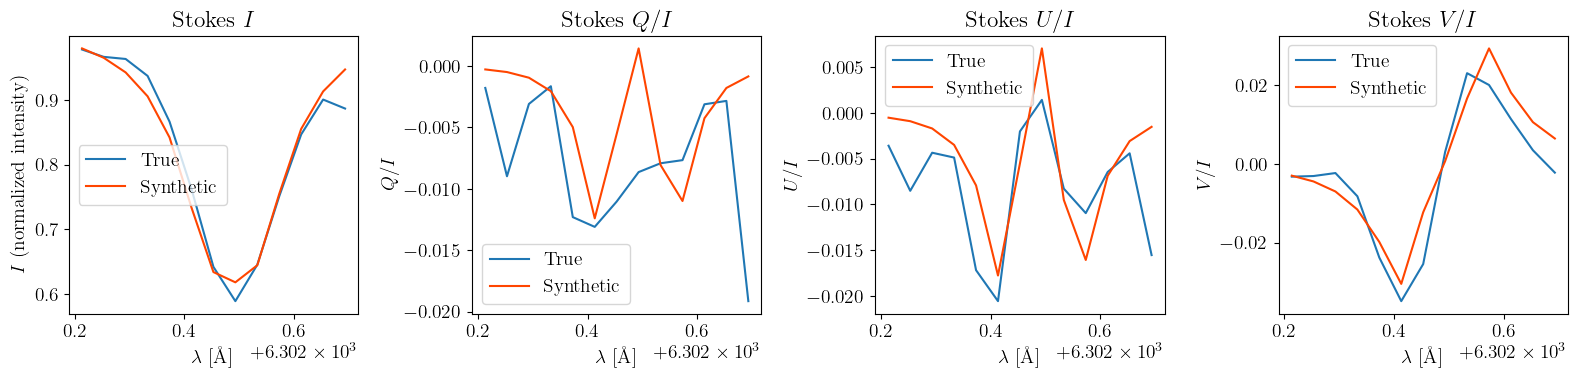

In [10]:
# Plot results for the first pixel of map 0
plot_stokes(map_inv_dict[0], syn_spectra_map_dict[0], np.array(regions_dict[0][0][0]), int(0), int(0), stokes_labels)

In [11]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cu121


# Train the normalizing flow
## Define training and testing datasets, dataloaders and train the flow

In [12]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [13]:
# Instantiate params dictionary
settings = dictionary()

In [14]:
# Reshape training data
spectra_map0 = map_inv_dict[0].reshape(map_inv_dict[0].shape[0]*map_inv_dict[0].shape[1], map_inv_dict[0].shape[2]*map_inv_dict[0].shape[3])
parameters_map0 = inverted_map_dict[0].reshape(inverted_map_dict[0].shape[0]*inverted_map_dict[0].shape[1], inverted_map_dict[0].shape[2])

# Create datasets of training data
spectra = spectra_map0
parameters = parameters_map0

In [15]:
# Print shape of data
print(f'Shape of true spectra data is: {spectra.shape}')
print(f'Shape of true parameters data is: {parameters.shape}')

Shape of true spectra data is: (330000, 52)
Shape of true parameters data is: (330000, 9)


In [16]:
# Test for NaN values in data
has_nan = np.isnan(spectra).any()
if has_nan==False:
    has_nan = np.isnan(parameters).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [17]:
# Define input x and context y
x = parameters # parameters
y = spectra # spectra

# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (297000, 9)
Context y_std_train shape: (297000, 52)
Output z_train shape: (297000, 9)
Input x_std_test shape: (33000, 9)
Context y_std_test shape: (33000, 52)
Output z_test shape: (33000, 9)


In [18]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [19]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([297000, 9])
Size of y_std_train: torch.Size([297000, 52])
Size of z_train: torch.Size([297000, 9])
Size of x_std_test: torch.Size([33000, 9])
Size of y_std_test: torch.Size([33000, 52])
Size of z_test: torch.Size([33000, 9])


In [20]:
# Define dataloaders for training and testing
settings.batch_size = 512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [21]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 16  # Try 128
settings.num_layers = 5 # Try 8

In [22]:
# Define functions for flow definitions
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

In [23]:
# Instantiate the normalizing flow
base_dist = StandardNormal(shape=[settings.input_size])
flowtransforms = []
for _ in range(settings.num_layers):
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
    flowtransforms.append(PiecewiseRationalQuadraticCouplingTransform(_, settings.input_size,
                                                                      settings.hidden_size, context_size=settings.context_size))
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
flowtransforms = CompositeTransform(flowtransforms)

flow = Flow(flowtransforms, base_dist)

In [24]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 10

# Define optimizer and scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

In [25]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        flow.train()
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        flow.eval()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/10 train loss: 0.0022
Epoch 1/10 test loss: -0.0049
Epoch 2/10 train loss: -0.0076
Epoch 2/10 test loss: -0.0088
Epoch 3/10 train loss: -0.0096
Epoch 3/10 test loss: -0.0099
Epoch 4/10 train loss: -0.0107
Epoch 4/10 test loss: -0.0108
Epoch 5/10 train loss: -0.0113
Epoch 5/10 test loss: -0.0112
Epoch 6/10 train loss: -0.0116
Epoch 6/10 test loss: -0.0113
Epoch 7/10 train loss: -0.0118
Epoch 7/10 test loss: -0.0115
Epoch 8/10 train loss: -0.0119
Epoch 8/10 test loss: -0.0116
Epoch 9/10 train loss: -0.0119
Epoch 9/10 test loss: -0.0116
Epoch 10/10 train loss: -0.0120
Epoch 10/10 test loss: -0.0116


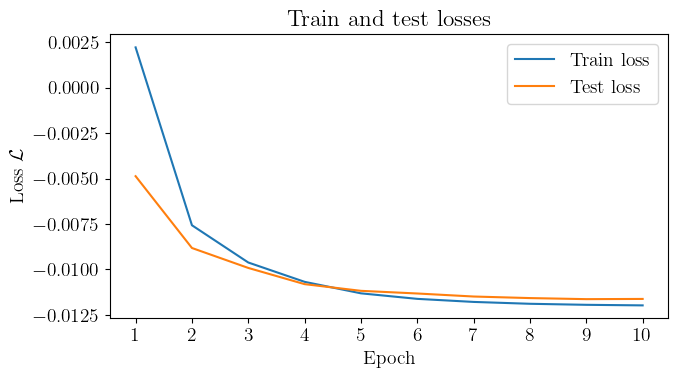

In [26]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-7-loss-nflows-piecewisequadratic.pdf')

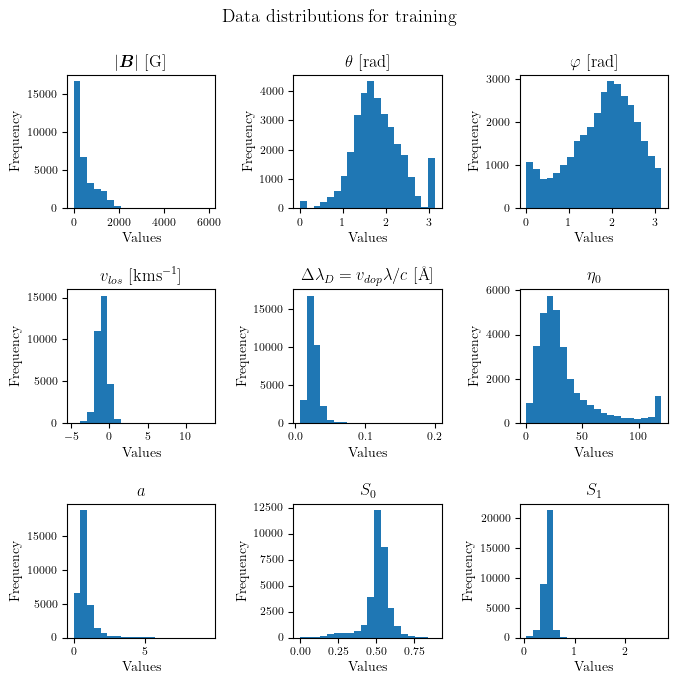

In [27]:
# Plot histogram of training data
plot_histograms(x_test, l_units, 'Data distributions for training', savename='nf-milne-eddington-example-7-datadistributiontraining-nflows-piecewisequadratic.pdf')

# Invert subsequent maps using the trained normalizing flow

## Provide a test example for the normalizing flow from the test dataset

In [28]:
# Take a sample from the testing map
settings.which_dataindex = 1000
settings.exp_samples = 5000
expval = x_test[settings.which_dataindex,:]
expobs = y_test[settings.which_dataindex,:]
z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_scaler_test.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x = x_scaler_test.inverse_transform(rec_x_std[0])

/home/dz/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(


In [29]:
# Plot actual values of features for tested spectrum
for i in range(len(labels)):
    print(f'{labels[i]}: {expval[i]}')

$|\bm{B}|$: 67.0102310180664
$\theta$: 1.5394630432128906
$\varphi$: 1.6912739276885986
$v_{los}$: -1.3175684213638306
$\Delta \lambda_D = v_{dop}\lambda/c$: 0.027689775452017784
$\eta_0$: 18.607213973999023
$a$: 0.37559154629707336
$S_0$: 0.5226978063583374
$S_1$: 0.5451894998550415


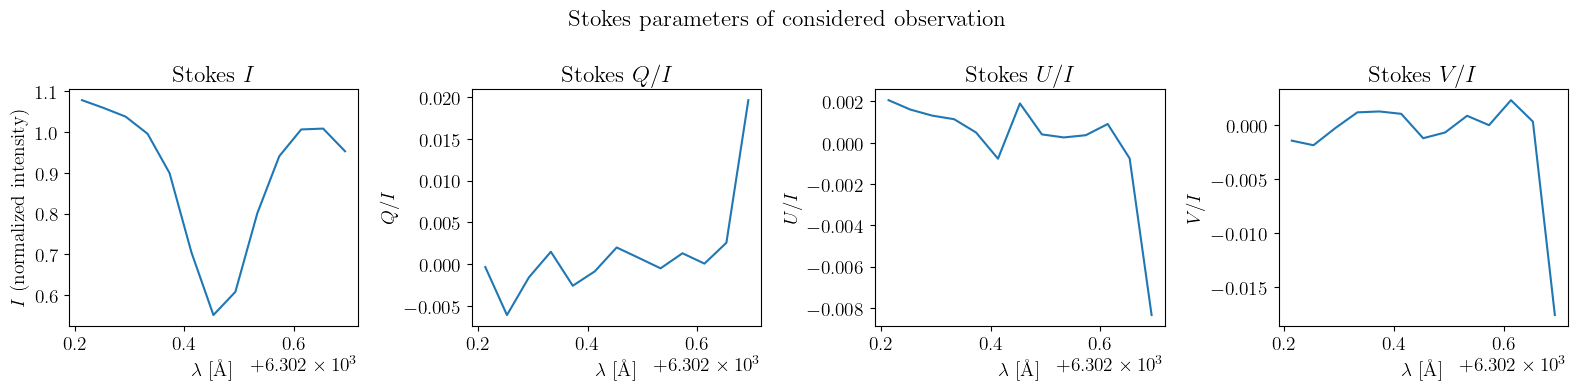

In [30]:
# Plot stokes profiles
plot_stokes_simple(y_test, regions_dict[0][0][0], settings.which_dataindex, stokes_labels,  title='Stokes parameters of considered observation', savename='nf-milne-eddington-example-7-corner-spectrum-nf-nflows-piecewisequadratic.pdf')

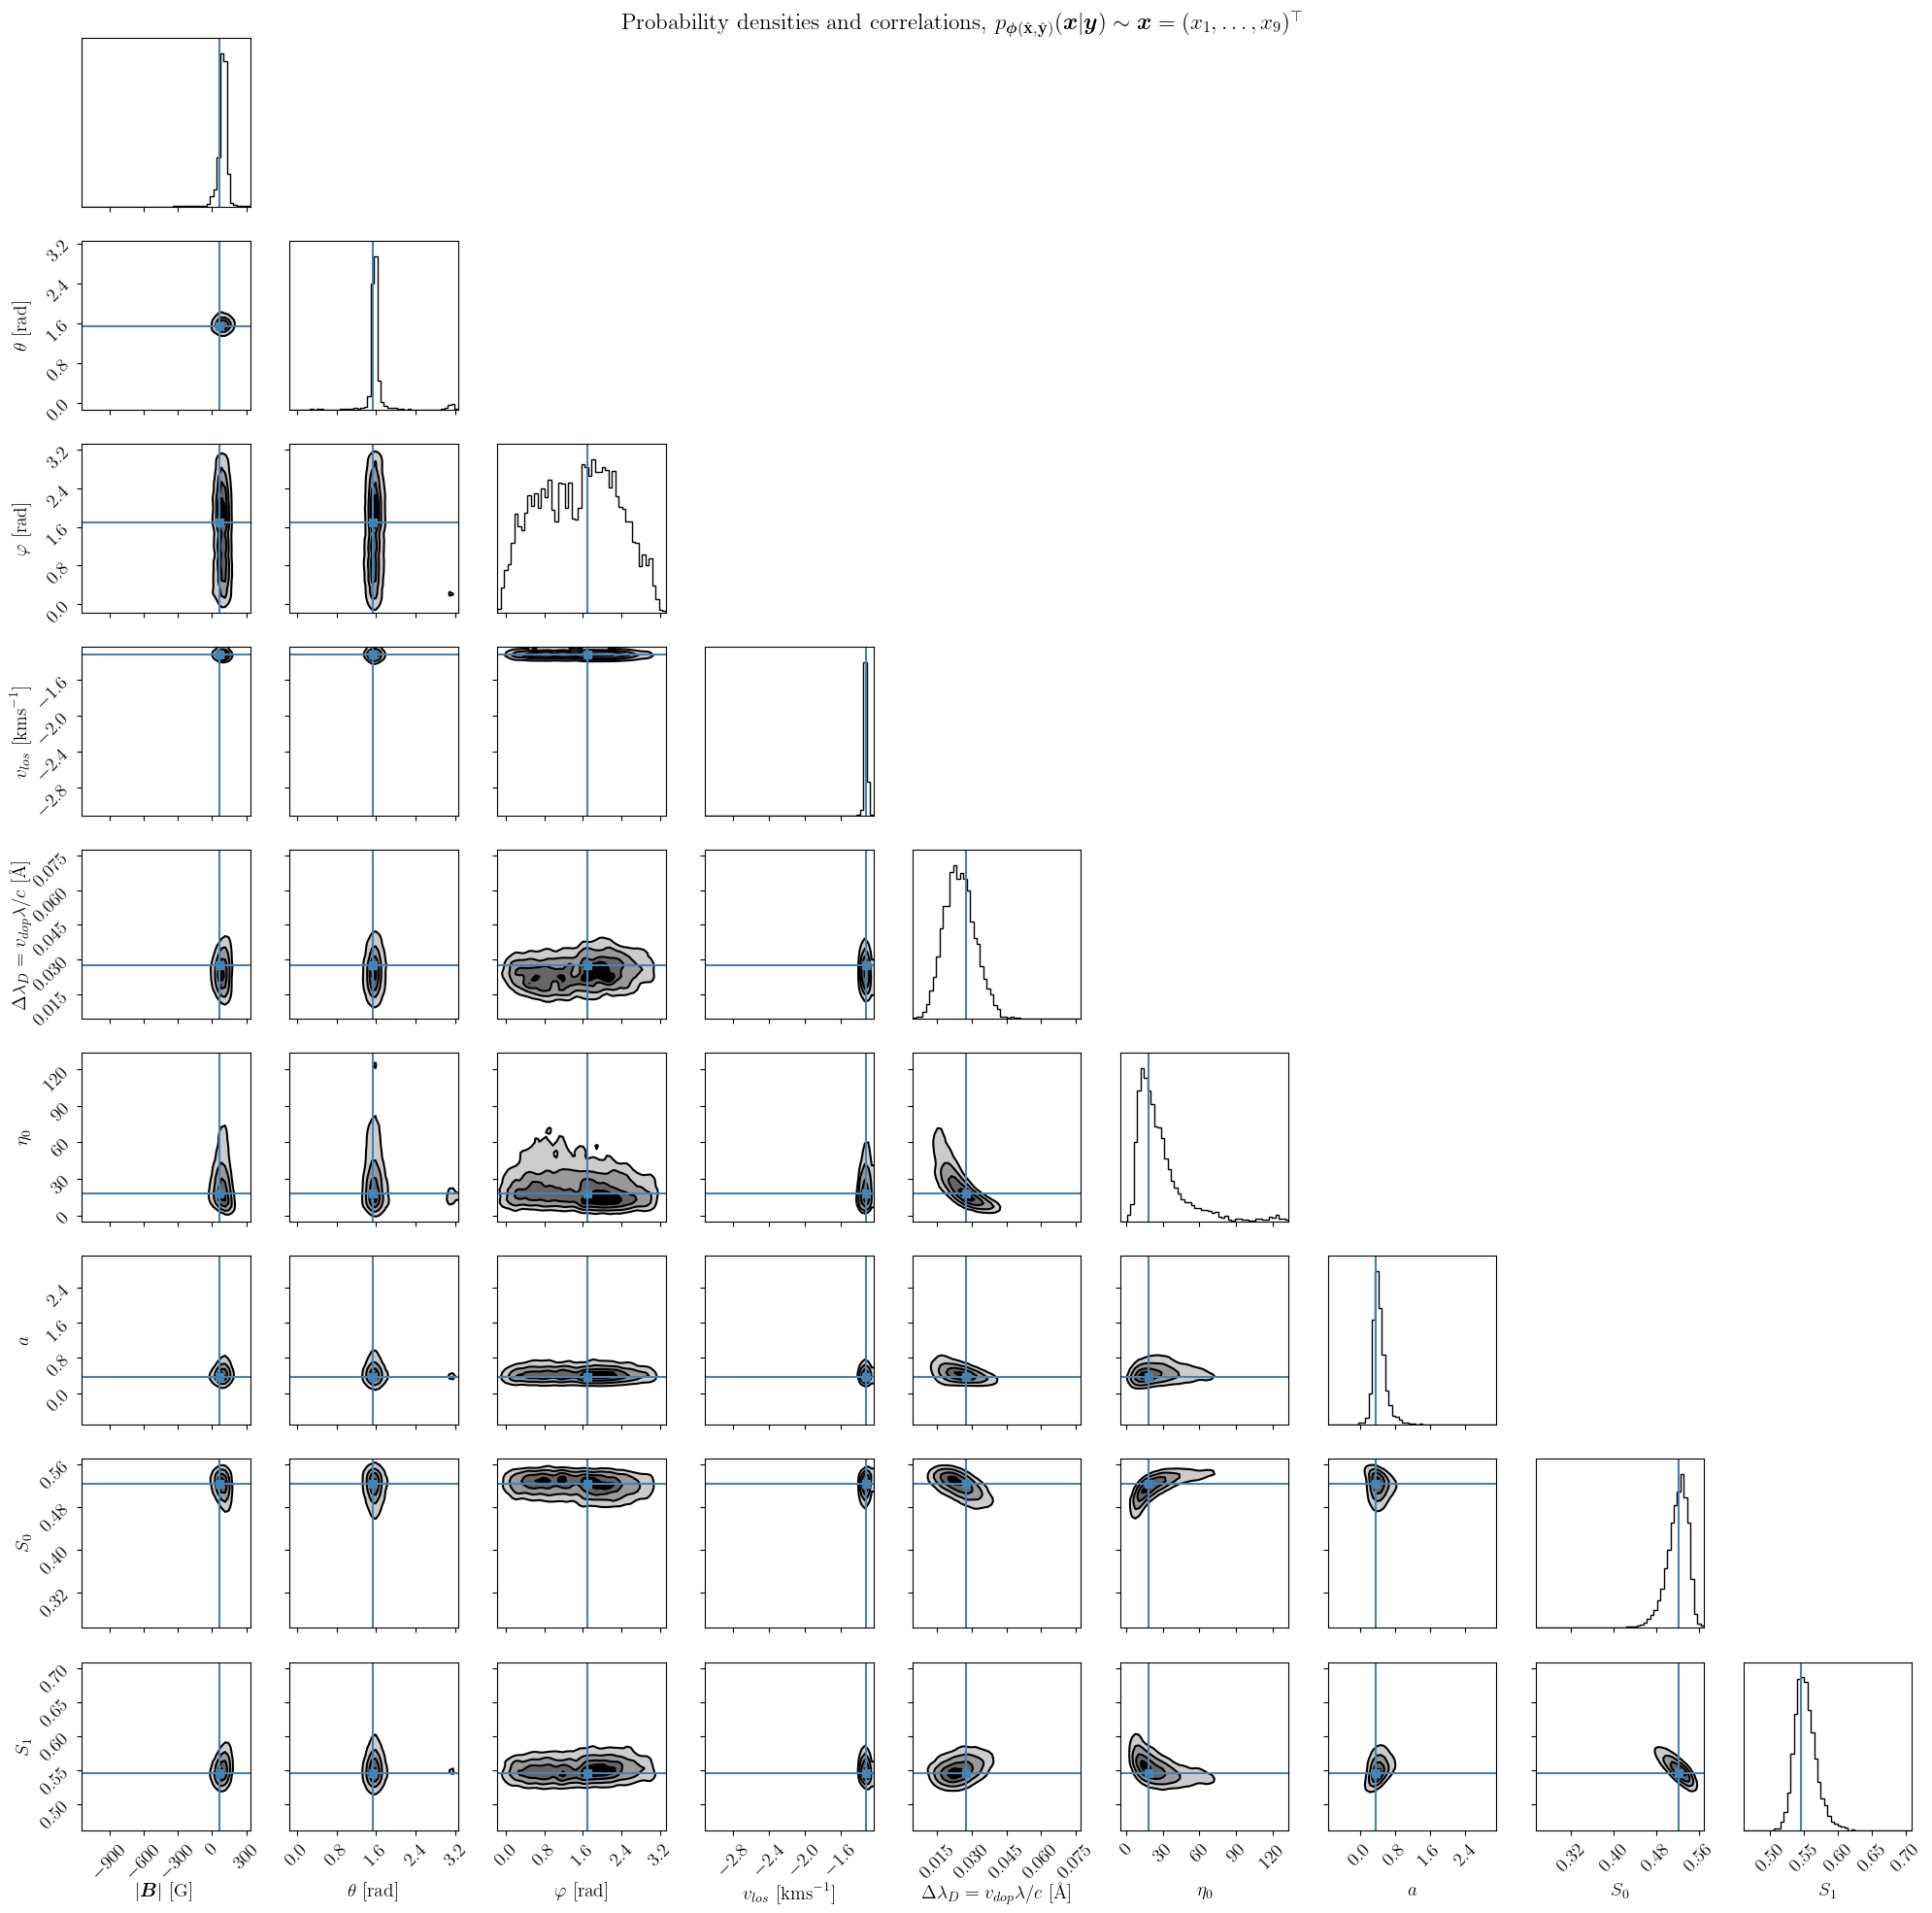

In [31]:
# Produce corner plot
figure = corner.corner(rec_x, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-7-corner-nflows-piecewisequadratic.pdf')

In [32]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

batch_size  :  512
input_size  :  9
context_size  :  52
hidden_size  :  16
num_layers  :  5
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  10
which_dataindex  :  1000
exp_samples  :  5000


## Invert all maps

In [33]:
# Define frames to invert
invert_frames = [0,1,2,4,6,7,8,9,10,11,13,14,16,17,18,19] # All available frames: [0,1,2,4,6,7,8,9,10,11,13,14,16,17,18,19]

In [34]:
def load_and_invert(invert_frames, flow, y_scaler, x_scaler):
    """
    Load and invert data.
    """
    # Load data
    base_path = '/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_{}.fits'
    save_params = '/home/dz/Python files/milne-eddington/nf-milne-eddington-example-7-nflows-piecewisequadratic/parameters_map{}.npy'
    save_param_errors = '/home/dz/Python files/milne-eddington/nf-milne-eddington-example-7-nflows-piecewisequadratic/err_parameters_map{}.npy'

    # Set number of parameters
    num_params = int(9)
    
    # Loop over all maps to invert
    for frame in invert_frames:
        # Load inverted map data
        file_path = base_path.format(frame)
        map_inv_frame, hdulist_frame, regions_frame = read_map_pf(file_path)
        spectra = map_inv_frame.reshape(map_inv_frame.shape[0]*map_inv_frame.shape[1], map_inv_frame.shape[2]*map_inv_frame.shape[3])

        # Invert map
        parameters, parameter_errors = invert_nflow(spectra, num_params, flow, y_scaler, x_scaler)

        # Save inverted map data
        save_p = save_params.format(frame)
        save_p_err = save_param_errors.format(frame)
        np.save(save_p, parameters)
        np.save(save_p_err, parameter_errors)

In [35]:
load_and_invert(invert_frames, flow, y_scaler_train, x_scaler_train)

100%|█████████████████████████████████████████████████████████████████████████| 330000/330000 [2:56:12<00:00, 31.21it/s]


# Do tests and plots
(Executable without executing the prior cells, except for the package imports).

In [1]:
# Import all important packages
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
import numpy as np
import seaborn as sns
from astropy.io import fits
from scipy.interpolate import CubicSpline
from matplotlib.patches import Rectangle

from utils import *

In [2]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

In [3]:
# Define frames to load
frames = [0,1,2,4,6,7,8,9,10,11,13,14,16,17,18,19] # All available frames: [0,1,2,4,6,7,8,9,10,11,13,14,16,17,18,19]
slit_position = int(320) # Value between 0 and 599, indicates horizontal slit position

In [4]:
def inv_params_loader(frames):
    # Define storage path
    storage_path = '/home/dz/Python files/milne-eddington/nf-milne-eddington-example-7-nflows-piecewisequadratic/parameters_map{}.npy'
    params_list = []
    for frame in frames:
        load_path = storage_path.format(frame)
        params_list.append(np.load(load_path).reshape(550,600,9))
    return params_list

In [5]:
def inv_errors_loader(frames):
    # Define storage path
    storage_path = '/home/dz/Python files/milne-eddington/nf-milne-eddington-example-7-nflows-piecewisequadratic/err_parameters_map{}.npy'
    params_list = []
    for frame in frames:
        load_path = storage_path.format(frame)
        params_list.append(np.load(load_path).reshape(550,600,9))
    return params_list

In [6]:
# Load parameters and errors
params_list = inv_params_loader(frames)
errors_list = inv_errors_loader(frames)

In [7]:
# Extract slit data
params_evol = extract_vertical_slices(params_list, center_index=slit_position)

In [8]:
# Get image of Stokes I for first and last map and first wavelength point (continuum)
bw_image_initial, bw_hdulist_initial, bw_regions_initial = read_map_pf('/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_0.fits')
bw_image_initial = bw_image_initial[:,:,0,0]
bw_image_final, bw_hdulist_finall, bw_regions_final = read_map_pf('/home/dz/maps/Complete dataset penumbra formation maps/Prepared_map_SIR_AR13010_nb_6302_2022-05-16T08_28_21_frame_18.fits')
bw_image_final = bw_image_final[:,:,0,0]

## Visualize data, possibility #1

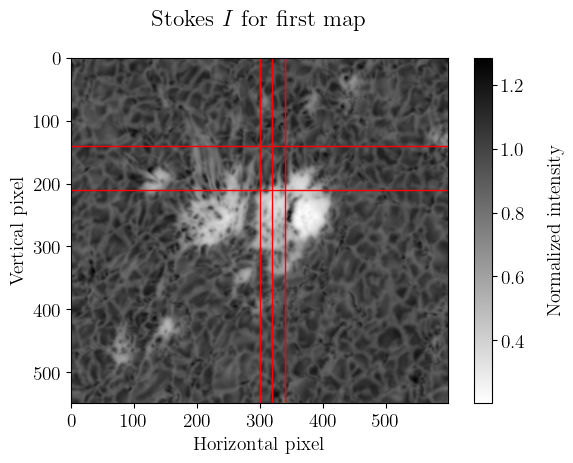

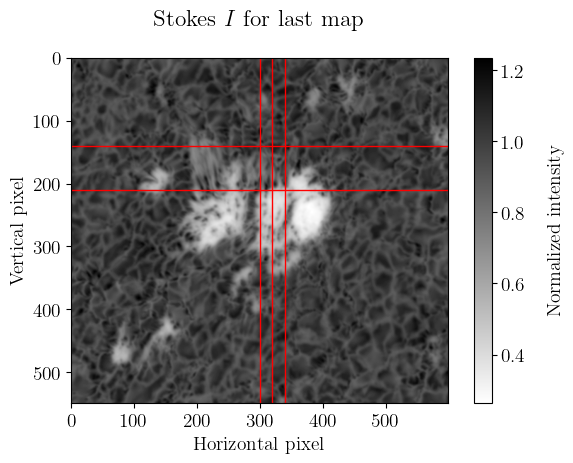

In [9]:
# Plot black and white map of Stokes I for first map and first wavelength point (continuum)
plt.title('Stokes $I$ for first map\n')
plt.imshow(bw_image_initial, cmap='binary')
plt.xlabel('Horizontal pixel')
plt.ylabel('Vertical pixel')
plt.axvline(x=300, color='red', linestyle='-', linewidth=1)
plt.axvline(x=320, color='red', linestyle='-', linewidth=1)
plt.axvline(x=340, color='red', linestyle='-', linewidth=1)
plt.axhline(y=140, color='red', linestyle='-', linewidth=1)
plt.axhline(y=210, color='red', linestyle='-', linewidth=1)
plt.colorbar().set_label('Normalized intensity', rotation=90, labelpad=15)
plt.tight_layout()
plt.show()

# Plot black and white map of Stokes I for last map and first wavelength point (continuum)
plt.title('Stokes $I$ for last map\n')
plt.imshow(bw_image_final, cmap='binary')
plt.xlabel('Horizontal pixel')
plt.ylabel('Vertical pixel')
plt.axvline(x=300, color='red', linestyle='-', linewidth=1)
plt.axvline(x=320, color='red', linestyle='-', linewidth=1)
plt.axvline(x=340, color='red', linestyle='-', linewidth=1)
plt.axhline(y=140, color='red', linestyle='-', linewidth=1)
plt.axhline(y=210, color='red', linestyle='-', linewidth=1)
plt.colorbar().set_label('Normalized intensity', rotation=90, labelpad=15)
plt.tight_layout()
plt.show()

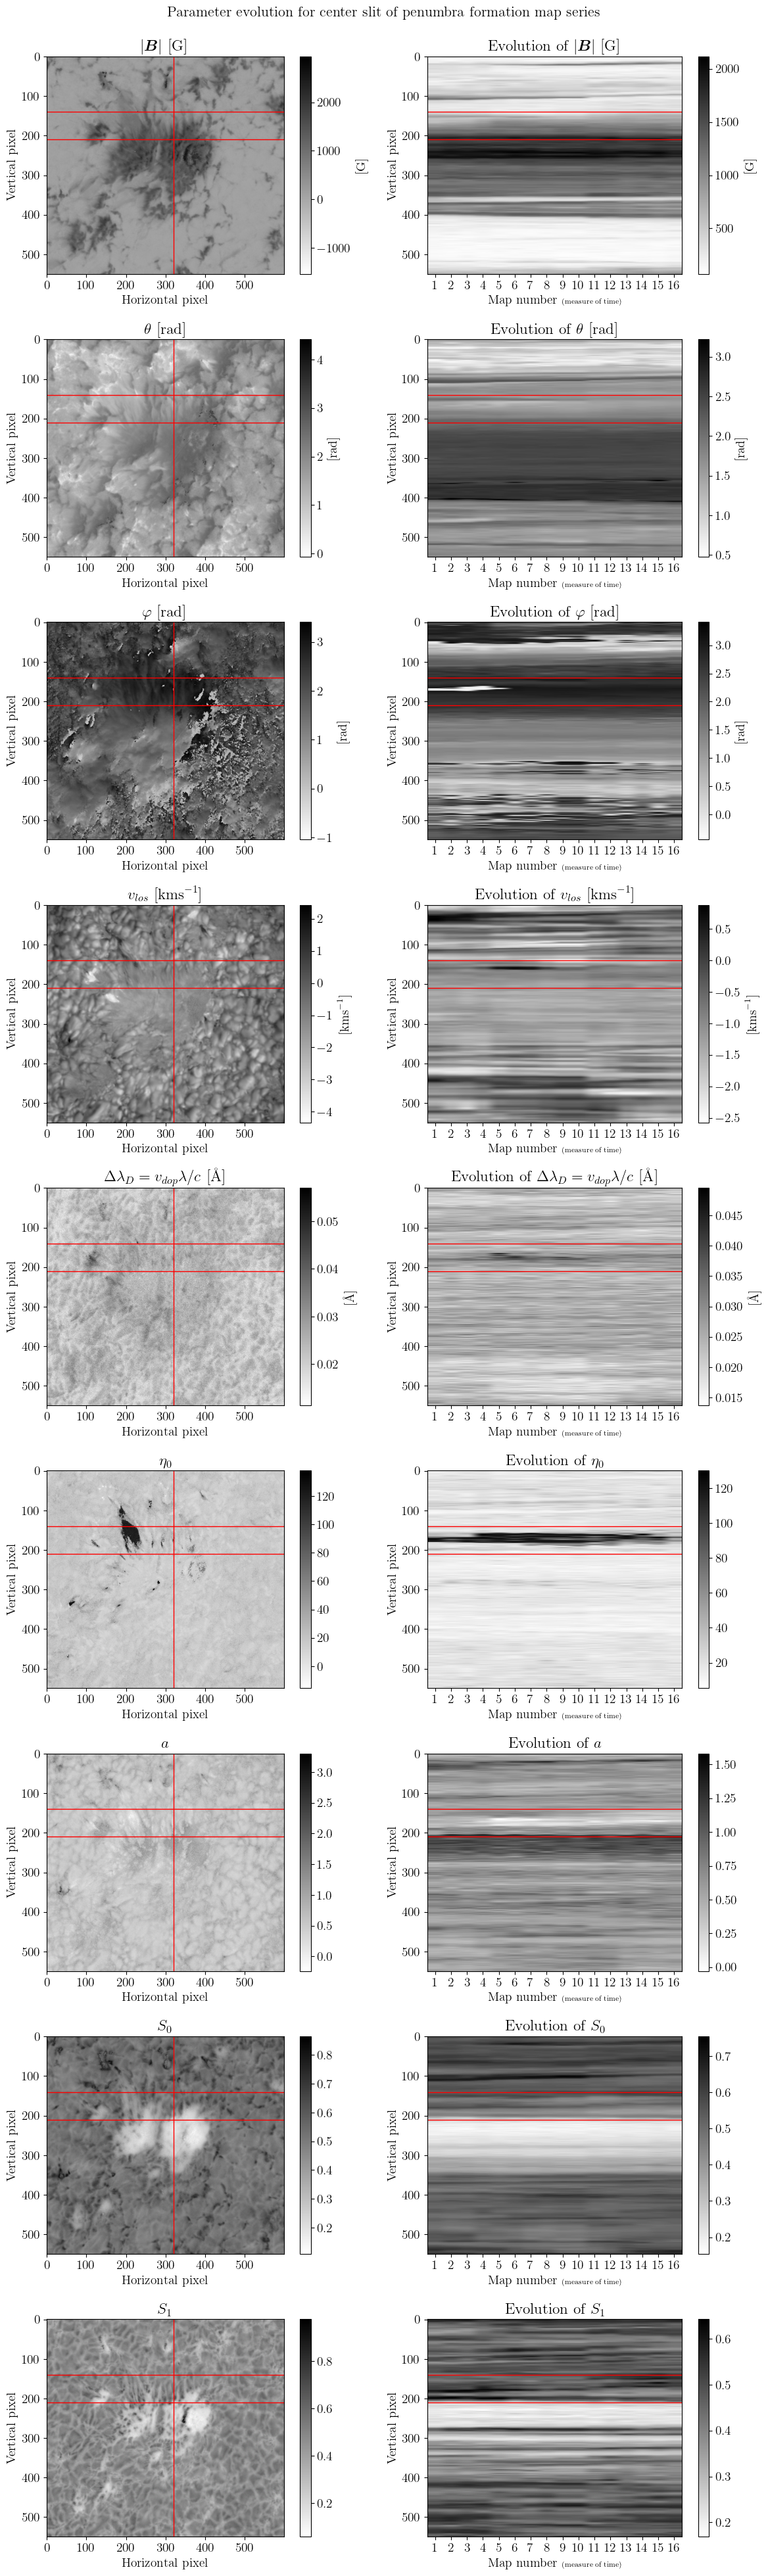

In [10]:
# PLot parameter evolution plot
plot_color_plots(params_evol, params_list[0], hl_pix_vert=slit_position, hl_max_hor=210, hl_min_hor=140, labels=l_units, units=units, title='Parameter evolution for center slit of penumbra formation map series\n\n\n', savename='nf-milne-eddington-example-7-evolution1-nflows-piecewisequadratic.pdf')

## Visualize data, possibility #2

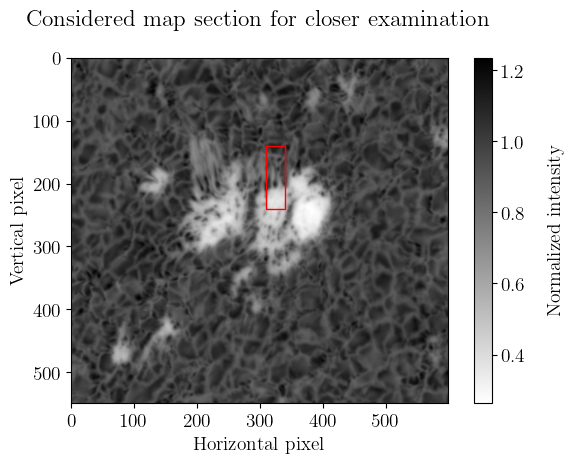

In [11]:
# Assuming bw_image_initial is your image array
# Replace these values with the actual position and size of your rectangle
rect_x = 310
rect_y = 140
rect_width = 30
rect_height = 100

# Plot black and white map of Stokes I for the first map and first wavelength point (continuum)
plt.title('Considered map section for closer examination\n')
plt.imshow(bw_image_final, cmap='binary')
plt.xlabel('Horizontal pixel')
plt.ylabel('Vertical pixel')
plt.colorbar().set_label('Normalized intensity', rotation=90, labelpad=15)

# Add a red rectangle to the plot
rectangle = Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=1, edgecolor='red', facecolor='none')
plt.gca().add_patch(rectangle)

# Show the plot
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-7-considered-map-section-nflows-piecewisequadratic.pdf')
plt.show()

In [12]:
# Call the function
param_evolution = extract_and_average_rectangles(params_list[0:], r=100, c=30, row_start=140, col_start=310)
error_evolution = extract_and_average_rectangles(errors_list[0:], r=100, c=30, row_start=140, col_start=310)

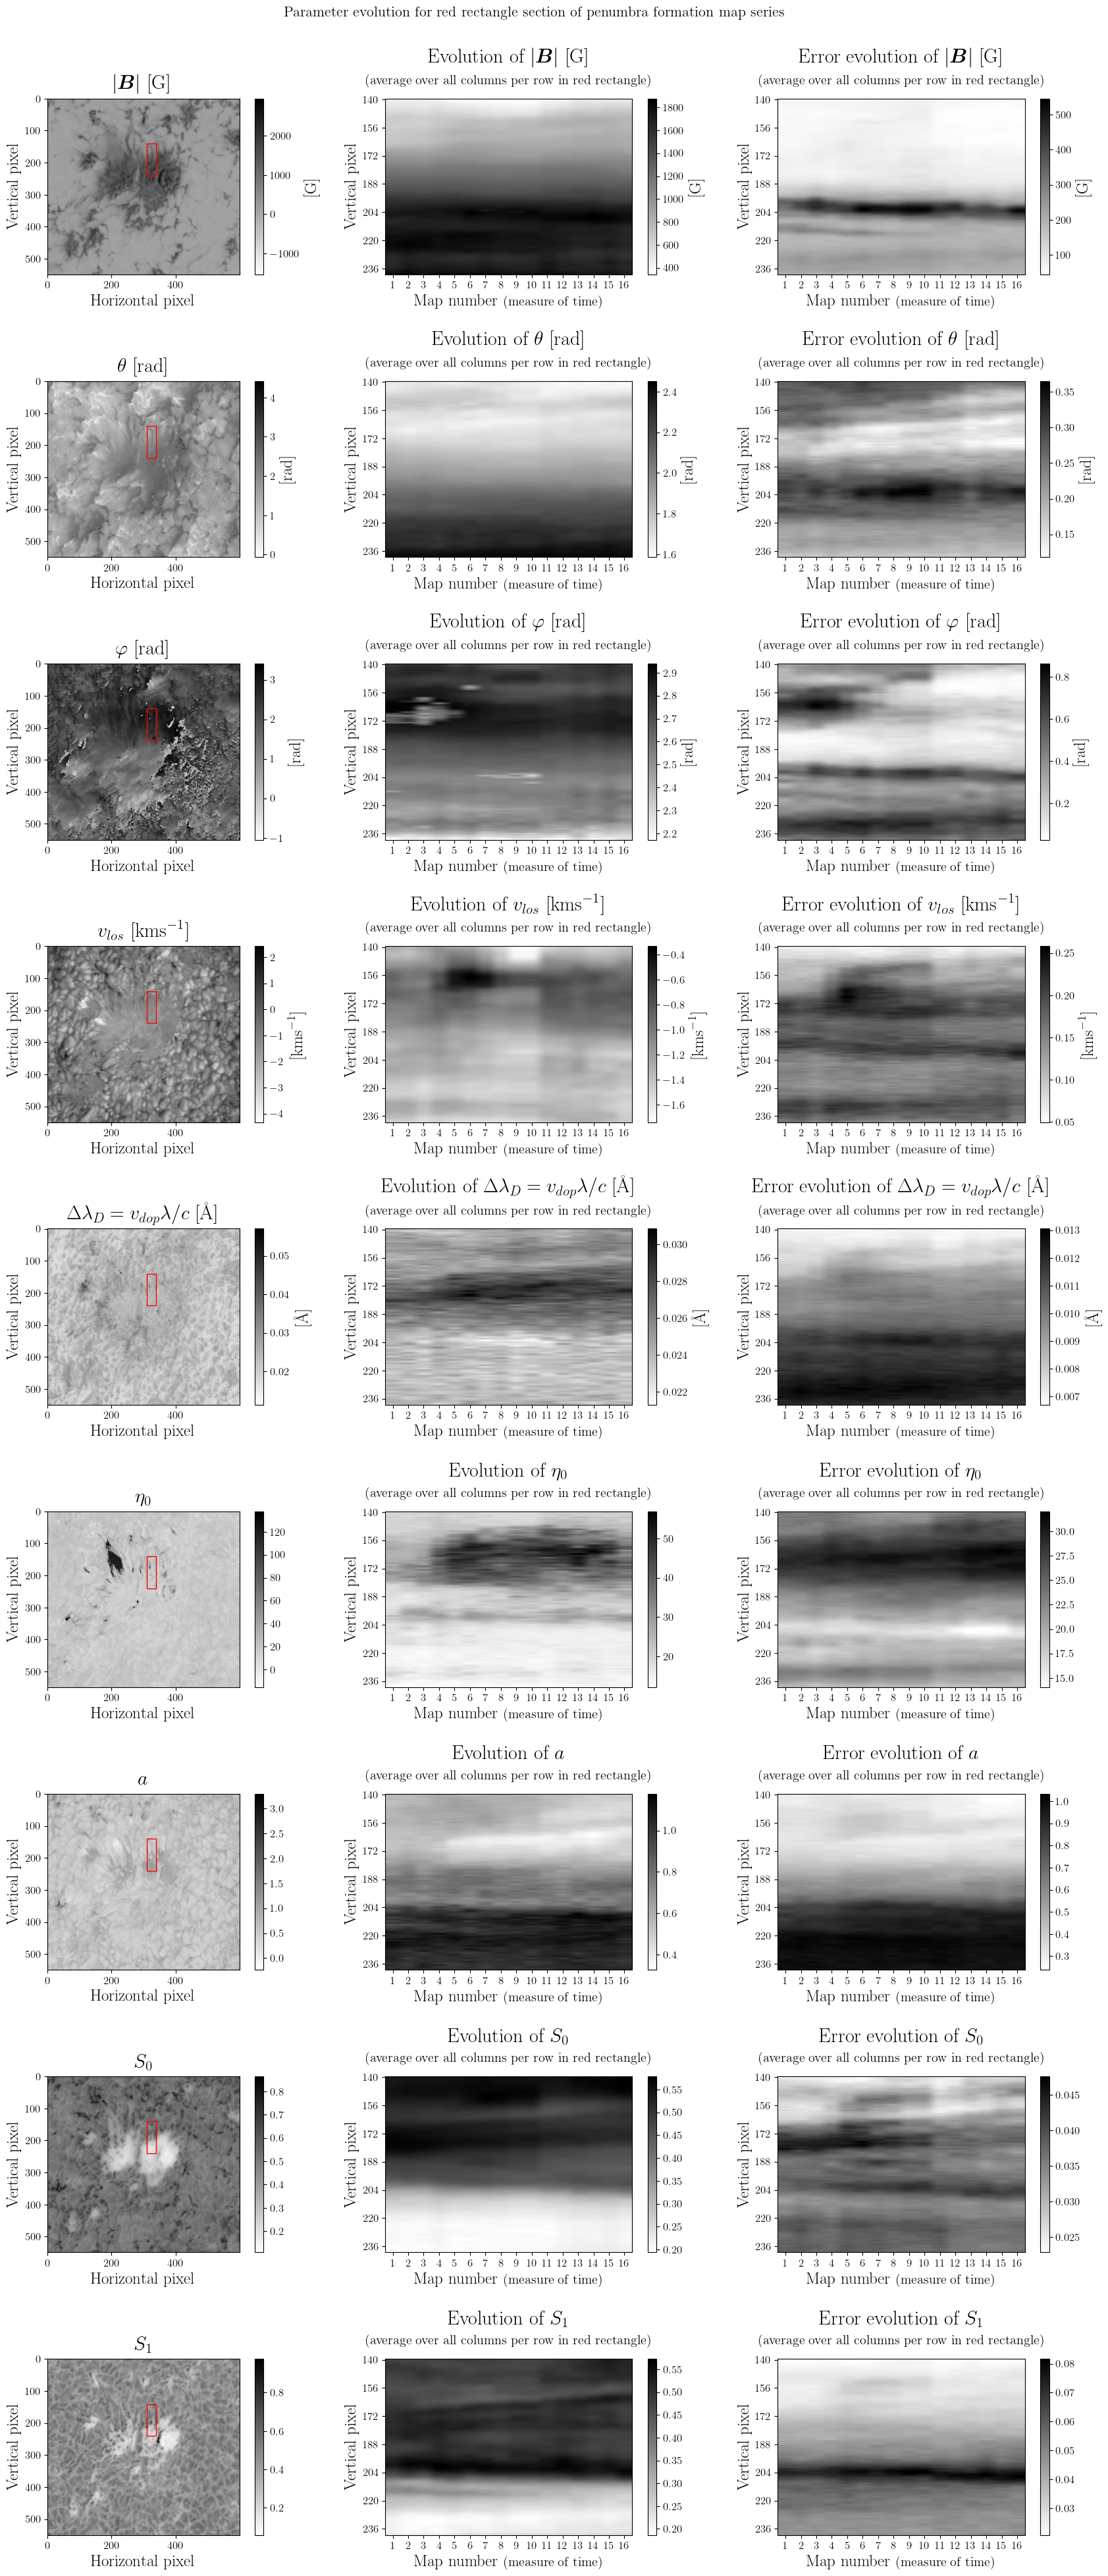

In [13]:
plot_color_plots_2(param_evolution, error_evolution, params_list[0], r=100, c=30, row_start=140, col_start=310, labels=l_units, units=units, title='Parameter evolution for red rectangle section of penumbra formation map series\n\n\n', savename='nf-milne-eddington-example-7-evolution2-nflows-piecewisequadratic.pdf')